# ETL Dataset homicidios, pestañas homicidios y víctimas

<br>

Importamos las librerías

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.colors as mcolors
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<br>

#### Dentro del Dataset provisto en formato xlsx, existen 2 pestañas con datos. Se procede a la extracción de las pestañas para su análisis

<br>

Se extraen los datos de la pestaña HECHOS del excel provisto.

In [147]:
# Se extrae la pestaña HECHOS del dataset HOMICIDIOS
df_homicidios_hechos = pd.read_excel(r"C:\Users\Cebol\OneDrive\Escritorio\PI_02_siniestros\Datasets\homicidios.xlsx", sheet_name='HECHOS')

# Se imprimen en pantalla las primeras filas
df_homicidios_hechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


<br>
<br>

Se observan los tipos de datos y cantidad de nulos

In [148]:
dicc = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_homicidios_hechos.columns:
    dicc["Campo"].append(columna)
    dicc["Tipo_de_dato"].append(df_homicidios_hechos[columna].apply(type).unique())
    dicc["Nulos"].append(df_homicidios_hechos[columna].isnull().sum())

df_info = pd.DataFrame(dicc)
df_info

,Campo,Tipo_de_dato,Nulos
0,ID,[<class 'str'>],0
1,N_VICTIMAS,[<class 'int'>],0
2,FECHA,[<class 'pandas._libs.tslibs.timestamps.Timest...,0
3,AAAA,[<class 'int'>],0
4,MM,[<class 'int'>],0
5,DD,[<class 'int'>],0
6,HORA,"[<class 'datetime.time'>, <class 'str'>, <clas...",0
7,HH,"[<class 'int'>, <class 'str'>]",0
8,LUGAR_DEL_HECHO,[<class 'str'>],0
9,TIPO_DE_CALLE,[<class 'str'>],0


<br>

En las columnas 'Altura' y 'Cruce' se encuentran la mayor cantidad de datos faltantes, debido a que se completa cuando el hecho ocurre en algún punto de la calle (Altura) o en la intersección de dos calles (Cruce). Se procede a completar los datos faltantes en la columna 'Dirección normalizada', luego eliminaré las columnas 'LUGAR_DEL_HECHO', 'Calle' y 'Altura'. Finalmente se cambiará el nombre de la columna 'Dirección Normalizada' por 'Lugar del Hecho'.

<br>


In [149]:
# Se rellenan los valores faltantes en la columna 'Dirección normalizada' con los valores de la columna 'LUGAR_DEL_HECHO' 
df_homicidios_hechos['Dirección Normalizada'].fillna(df_homicidios_hechos['LUGAR_DEL_HECHO'], inplace=True)

# Se chequea la cantidad de nulos en la columna 'Dirección Normalizada'
df_homicidios_hechos['Dirección Normalizada'].isna().sum()

0

<br>
<br>

Se procede a eliminar las columnas

In [150]:
# Se eliminan las columnas
df_homicidios_hechos = df_homicidios_hechos.drop(['LUGAR_DEL_HECHO', 'Calle', 'Altura'], axis=1)

# Se confirma 
df_homicidios_hechos.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'TIPO_DE_CALLE', 'Cruce', 'Dirección Normalizada', 'COMUNA',
       'XY (CABA)', 'pos x', 'pos y', 'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

<br>
<br>

Se modifica el nombre de la columna 'Dirección Normalizada'

In [151]:
# Cambio el nombre de la columna 'Dirección Normalizada' a 'LUGAR DEL HECHO'
df_homicidios_hechos = df_homicidios_hechos.rename(columns={'Dirección Normalizada': 'Lugar del Hecho'})

<br>
<br>

La columna 'Cruce' no se elimina para poder estudiar de forma mas fácil si los accidentes ocurren en una intersección de calles o no. Para ello se reemplazan los valores de la columna con SI y NO, según corresponda con el lugar del hecho.

In [152]:
# Se reemplazan los valores NULOS por "No" y los NO NULOS por "Si"
df_homicidios_hechos['Cruce'] = np.where(df_homicidios_hechos['Cruce'].notnull(), 'SI', 'NO')

# Se revisa la columna
df_homicidios_hechos[['Cruce', 'Lugar del Hecho']]

,Cruce,Lugar del Hecho
0,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G..."
1,SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV."
2,NO,ENTRE RIOS AV. 2034
3,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL."
4,SI,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES."
...,...,...
691,SI,RIESTRA AV. y MOM
692,SI,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV."
693,SI,GAONA AV. y TERRADA
694,NO,"PERON, EVA AV. 4071"


<br>
<br>

#### Se estandarizan los nombres de las columnas

In [153]:
# Se coloca la primera en mayúscula
df_homicidios_hechos.columns = [x.capitalize() for x in df_homicidios_hechos.columns]

# Se reemplazan los guiones por espacios
df_homicidios_hechos.columns = df_homicidios_hechos.columns.str.replace('_', ' ')

# Se renombran algunas columnas
df_homicidios_hechos = df_homicidios_hechos.rename(columns={'N victimas': 'Nro Víctimas',
                                                      'Aaaa':'Año',
                                                      'Mm':'Mes',
                                                      'Dd':'Día',
                                                      'Hh':'Hora Estandar',
                                                      'Xy (caba)':'XY (CABA)',
                                                      'Victima':'Víctima'})
df_homicidios_hechos.columns

Index(['Id', 'Nro Víctimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora Estandar', 'Tipo de calle', 'Cruce', 'Lugar del hecho', 'Comuna',
       'XY (CABA)', 'Pos x', 'Pos y', 'Participantes', 'Víctima', 'Acusado'],
      dtype='object')

<br>
<br>

#### Se reemplazan los caracteres, particularmente la Ñ, que no son resueltos con diferentes codificaciones del archivo porque están mal provistos desde el origen.


In [154]:
# Utilización de regex para corregir los valores
df_homicidios_hechos.replace(to_replace=['Ã‘', r'\?'], value=['Ñ', 'Ñ'], regex=True, inplace=True)

<br>
<br>

#### Se chequean los registros duplicados

In [155]:
filas_duplicadas = df_homicidios_hechos[df_homicidios_hechos.duplicated(subset='Id', keep=False)]
filas_duplicadas

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado


No se encontraron valores DUPLICADOS.

<br>
<br>

#### Se normalizan los tipos de datos en las columnas 'Hora' y 'Hora Estandar'

In [156]:
# Función que convierte un valor a un objeto de tiempo (time) de Python, si es posible
def convertir_hora(x):
    if isinstance(x, str):
        try:
            return datetime.strptime(x, "%H:%M:%S").time()
        except ValueError:
            return None
    elif isinstance(x, datetime):
        return x.time()
    return x

# Se cambia el tipo de dato en la columna 'Hora'
df_homicidios_hechos['Hora'] = df_homicidios_hechos['Hora'].apply(lambda x: convertir_hora(x))

df_homicidios_hechos[df_homicidios_hechos['Hora'].isna()]

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
518,2019-0103,1,2019-12-18,2019,12,18,None,SD,GRAL PAZ,SI,"PAZ, GRAL. AV. y GRIVEO",11,Point (94643.11254058 103831.57115061),-58.52169422,-34.59471640,MOTO-MOTO,MOTO,MOTO


<br>

Se imputa el dato faltante con la moda

In [157]:
# Se calcula la hora mas común
hora_moda = df_homicidios_hechos['Hora'].mode().iloc[0]

# Se reemplaza el valor None por la hora más común
df_homicidios_hechos['Hora'].fillna(hora_moda, inplace=True)

# Se verifica el tipo de dato para la columna
df_homicidios_hechos['Hora'].apply(type).value_counts()

Hora
<class 'datetime.time'>    696
Name: count, dtype: int64

<br>

Se imputa tambien en la columna 'Hora Estandar' el dato faltante, con la moda

In [158]:
# Se imputa la hora moda al dato faltante
df_homicidios_hechos['Hora Estandar'] = df_homicidios_hechos['Hora Estandar'].apply(lambda x: int(hora_moda.hour) if x == "SD" else x)

# Se verifica el tipo de dato
df_homicidios_hechos['Hora Estandar'].apply(type).value_counts()

Hora Estandar
<class 'int'>    696
Name: count, dtype: int64

<br>
<br>

#### Se verifican nuevamente los tipos de datos y nulos

In [159]:
dicc = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_homicidios_hechos.columns:
    dicc["Campo"].append(columna)
    dicc["Tipo_de_dato"].append(df_homicidios_hechos[columna].apply(type).unique())
    dicc["Nulos"].append(df_homicidios_hechos[columna].isnull().sum())

df_info = pd.DataFrame(dicc)
df_info

,Campo,Tipo_de_dato,Nulos
0,Id,[<class 'str'>],0
1,Nro Víctimas,[<class 'int'>],0
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,0
3,Año,[<class 'int'>],0
4,Mes,[<class 'int'>],0
5,Día,[<class 'int'>],0
6,Hora,[<class 'datetime.time'>],0
7,Hora Estandar,[<class 'int'>],0
8,Tipo de calle,[<class 'str'>],0
9,Cruce,[<class 'str'>],0


<br>
<br>

Se corrigen los registros de la columna 'Víctimas' para que esté en concordancia con la pestaña de datos

In [160]:
# Se observan los valores únicos
df_homicidios_hechos['Víctima'].unique()

array(['MOTO', 'AUTO', 'PEATON', 'SD', 'CARGAS', 'BICICLETA', 'PASAJEROS',
       'MOVIL', 'OBJETO FIJO', 'PEATON_MOTO'], dtype=object)

In [161]:
# Se modifican los valores fuera del diccionario de datos, segun el dataset original
df_homicidios_hechos['Víctima'] = df_homicidios_hechos['Víctima'].replace({'OBJETO FIJO':'AUTO', 'PEATON_MOTO':'PEATON'})

<br>
<br>

Se elimina de la columna 'Acusado' el valor 'Objeto fijo' cuando el accidente ocurre entre un auto y un objeto fijo, por ejemplo. El objeto fijo no puede ser ni víctima ni acusado. 

In [162]:
# Aplico una función lambda para reemplazar 'OBJETO FIJO' con el valor de 'Víctima'
df_homicidios_hechos['Acusado'] = df_homicidios_hechos.apply(
    lambda fila: fila['Víctima'] if fila['Acusado'] == 'OBJETO FIJO' else fila['Acusado'],
    axis=1
)

<br>
<br>

#### Valores faltantes en variables geográficas

In [163]:
# Se analizan los registro vacíos en 'XY (CABA)'
df_homicidios_hechos[df_homicidios_hechos['XY (CABA)']=='Point (. .)']

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
35,2016-0049,1,2016-04-17,2016,4,17,00:00:00,0,AUTOPISTA,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,Point (. .),-58.37714647568196,-34.63657525428238,SD-SD,SD,SD
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA,NO,AUTOPISTA LUGONES PK 10000,13,Point (. .),.,.,MOTO-SD,MOTO,SD
71,2016-0096,1,2016-07-25,2016,7,25,07:00:00,7,AUTOPISTA,NO,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,8,Point (. .),-58.47433193007387,-34.66684950051973,MOTO-CARGAS,MOTO,CARGAS
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AUTOPISTA,NO,AU BUENOS AIRES - LA PLATA KM. 4,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,CALLE,NO,SD,0,Point (. .),.,.,PEATON-SD,PEATON,SD
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA,NO,AUTOPISTA 25 DE MAYO,0,Point (. .),.,.,SD-SD,SD,SD
176,2017-0042,1,2017-04-10,2017,4,10,09:00:00,9,GRAL PAZ,NO,"LUGONES, LEOPOLDO AV.",14,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
180,2017-0050,2,2017-04-28,2017,4,28,11:08:08,11,AUTOPISTA,NO,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,9,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
181,2017-0051,1,2017-05-01,2017,5,1,03:47:47,3,AUTOPISTA,NO,AU DELLEPIANE 2400,7,Point (. .),.,.,AUTO-AUTO,AUTO,AUTO
256,2017-0140,1,2017-11-19,2017,11,19,23:22:17,23,AUTOPISTA,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,Point (. .),.,.,MOTO-PASAJEROS,MOTO,PASAJEROS


Se podrían completar los valores de forma manual al contar con la información de la columna 'Lugar del Hecho', pero no es el objetivo de este proyecto. Por lo tanto, se decide eliminar la columna XY (CABA) e imputar los valores faltantes con 0 para poder utilizar estos registros en el EDA.

In [164]:
# Se elimina la columna 'XY (CABA)'
df_homicidios_hechos = df_homicidios_hechos.drop(['XY (CABA)'], axis=1)

# Se reemplazan los valores faltantes por 0
df_homicidios_hechos['Pos x'] = df_homicidios_hechos['Pos x'].replace('.', 0)
df_homicidios_hechos['Pos y'] = df_homicidios_hechos['Pos y'].replace('.', 0)

<br>
<br>

Se deja el Dataframe listo para fusionarlo luego el Dataframe de la pestaña víctimas, copiando las filas que tienen valor mayor a 1 en el número de víctimas, ya que el dataset 'víctimas' contiene una fila por cada víctima, en siniestros con multiples víctimas.

In [165]:
# Se crea un nuevo Dataframe que contiene filas adicionales en caso de que haya mas de 1 víctima
filas_expandidas = []

for index, row in df_homicidios_hechos.iterrows():
    n_victimas = row['Nro Víctimas']
    
    if n_victimas > 1:
        filas_adicionales = pd.DataFrame([row] * (n_victimas - 1))
        
        # Se agregan las filas adicionales 
        filas_expandidas.append(filas_adicionales)

# Se concatena el Dataframe original con el que tiene las filas adicionales
df_homicidios_hechos = pd.concat([df_homicidios_hechos] + filas_expandidas, ignore_index=True)

"""# Print the expanded DataFrame
df_homicidios_hechos.drop(columns='N_VICTIMAS', inplace=True)
df_homicidios_hechos"""

"# Print the expanded DataFrame\ndf_homicidios_hechos.drop(columns='N_VICTIMAS', inplace=True)\ndf_homicidios_hechos"

<br>
<br>

#### Se observa como quedó finalmente el Dataframe de la pestaña Homicidios

In [166]:
# Se imprimen en pantalla las primeras filas
df_homicidios_hechos.head()

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,Pos x,Pos y,Participantes,Víctima,Acusado
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AVENIDA,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,GRAL PAZ,SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AVENIDA,NO,ENTRE RIOS AV. 2034,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AVENIDA,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AVENIDA,SI,"SAN JUAN AV. y SAENZ PEÑA, LUIS, PRES.",1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


<br>
<br>



<br>
<br>

#### Se extraen los datos de la pestaña VICTIMAS del excel provisto.

In [167]:
# Se extrae la pestaña VICTIMAS del dataset HOMICIDIOS
df_homicidios_victimas = pd.read_excel(r"C:\Users\Cebol\OneDrive\Escritorio\PI_02_siniestros\Datasets\homicidios.xlsx", sheet_name='VICTIMAS')

# Se imprimen en pantalla las primeras filas
df_homicidios_victimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


<br>
<br>

Del dataset Víctimas, se adicionan los datos relativos a Rol, Sexo, Edad y Fecha de fallecimiento de la víctima.

In [168]:
# Se realiza un merge para combinar al dataframe homicidios solo las columnas nuevas del dataset de la pestaña víctimas
df_homicidios = df_homicidios_hechos.merge(
    df_homicidios_victimas[['ID_hecho', 'ROL', 'SEXO', 'EDAD', 'FECHA_FALLECIMIENTO']],
    left_on='Id', right_on='ID_hecho', how='left')

# Se elimina la columna duplicada 'ID_hecho' a partir de la cual se realizó el merge con 'Id'
df_homicidios.drop(columns='ID_hecho', inplace=True)
df_homicidios.head()

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,...,Comuna,Pos x,Pos y,Participantes,Víctima,Acusado,ROL,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AVENIDA,SI,...,8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,GRAL PAZ,SI,...,9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AVENIDA,NO,...,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AVENIDA,SI,...,8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,CONDUCTOR,MASCULINO,18,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AVENIDA,SI,...,1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29,2016-02-01 00:00:00


<br>
<br>

Se chequean los valores duplicados luego del merge

In [169]:
# Se chequean las filas duplicadas, cuando coinciden 'Id', 'Nro Víctimas' y 'ROL' 
filas_duplicadas = df_homicidios[df_homicidios.duplicated(subset=["Id", "Nro Víctimas", "ROL"], keep=False)]
filas_duplicadas

,Id,Nro Víctimas,Fecha,Año,Mes,Día,Hora,Hora Estandar,Tipo de calle,Cruce,...,Comuna,Pos x,Pos y,Participantes,Víctima,Acusado,ROL,SEXO,EDAD,FECHA_FALLECIMIENTO
29,2016-0041,2,2016-03-29,2016,3,29,11:00:00,11,AVENIDA,SI,...,7,-58.46076550,-34.63350444,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,54,2016-03-29 00:00:00
30,2016-0041,2,2016-03-29,2016,3,29,11:00:00,11,AVENIDA,SI,...,7,-58.46076550,-34.63350444,MOTO-CARGAS,MOTO,CARGAS,PASAJERO_ACOMPAÑANTE,MASCULINO,SD,2016-03-30 00:00:00
98,2016-0126,2,2016-09-18,2016,9,18,22:45:00,22,CALLE,SI,...,10,-58.52572109,-34.62125906,AUTO-CARGAS,AUTO,CARGAS,CONDUCTOR,MASCULINO,37,SD
99,2016-0126,2,2016-09-18,2016,9,18,22:45:00,22,CALLE,SI,...,10,-58.52572109,-34.62125906,AUTO-CARGAS,AUTO,CARGAS,PASAJERO_ACOMPAÑANTE,MASCULINO,60,SD
163,2017-0026,2,2017-02-26,2017,2,26,05:15:00,5,AVENIDA,SI,...,4,-58.41842777,-34.64979057,AUTO-OBJETO FIJO,AUTO,AUTO,PASAJERO_ACOMPAÑANTE,FEMENINO,23,2017-02-26 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,2020-0038,2,2020-08-30,2020,8,30,04:00:00,4,AVENIDA,SI,...,14,-58.40617526,-34.58345898,AUTO-AUTO,AUTO,AUTO,CONDUCTOR,MASCULINO,64,2020-08-30 00:00:00
757,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,CALLE,SI,...,11,-58.52783814,-34.61047001,PEATON_MOTO-MOTO,PEATON,MOTO,PEATON,MASCULINO,38,2020-12-05 00:00:00
758,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,CALLE,SI,...,11,-58.52783814,-34.61047001,PEATON_MOTO-MOTO,PEATON,MOTO,PASAJERO_ACOMPAÑANTE,MASCULINO,21,2020-12-05 00:00:00
759,2020-0077,2,2020-12-25,2020,12,25,06:40:00,6,AVENIDA,SI,...,15,-58.47220945,-34.60111373,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,FEMENINO,30,2020-12-25 00:00:00


<br>

Se procede a eliminar las columnas duplicadas

In [170]:
# Se eliminan las columnas duplicadas, que coincidan con el criterio aplicado para buscar duplicados
df_homicidios_sin_duplicados = df_homicidios.drop_duplicates(subset=["Id", "Nro Víctimas", "ROL"], keep=False)

<br>
<br>

Se observan los tipos de datos y los valores nulos luego del merge

In [171]:
dicc = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_homicidios.columns:
    dicc["Campo"].append(columna)
    dicc["Tipo_de_dato"].append(df_homicidios[columna].apply(type).unique())
    dicc["Nulos"].append(df_homicidios[columna].isnull().sum())

df_info = pd.DataFrame(dicc)
df_info

,Campo,Tipo_de_dato,Nulos
0,Id,[<class 'str'>],0
1,Nro Víctimas,[<class 'int'>],0
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,0
3,Año,[<class 'int'>],0
4,Mes,[<class 'int'>],0
5,Día,[<class 'int'>],0
6,Hora,[<class 'datetime.time'>],0
7,Hora Estandar,[<class 'int'>],0
8,Tipo de calle,[<class 'str'>],0
9,Cruce,[<class 'str'>],0


<br>
<br>

Existen valores string 'SD' en la columna Edad, que se decide imputarlos por el promedio segun el sexo de la víctima, dado que la moda en ambos casos es 30 años, y no me termina de convencer.

In [172]:
# Reemplazar 'SD' por NaN en la columna 'Edad'
df_homicidios['EDAD'] = df_homicidios['EDAD'].replace('SD', pd.NA)

# Calcular el promedio de la columna 'Edad' agrupada por 'Sexo' y convertirlo a parte entera
promedio_por_sexo = df_homicidios.groupby('SEXO')['EDAD'].mean().apply(lambda x: int(x) if not pd.isna(x) else pd.NA).to_dict()

# Imputar los valores NaN en la columna 'Edad' con el promedio correspondiente al 'Sexo'
df_homicidios['EDAD'] = df_homicidios.apply(lambda row: promedio_por_sexo[row['SEXO']] if pd.isna(row['EDAD']) and row['SEXO'] != 'SD' else 30 if pd.isna(row['EDAD']) and row['SEXO'] == 'SD' else row['EDAD'], axis=1)

<br>
<br>

Se imputa el valor de la comuna 0, dado que dicha comuna no existe, y se reemplaza por el valor de la moda de esta columna

In [173]:
# Calcular la moda de la columna "Comuna"
moda_comuna = df_homicidios['Comuna'].mode()[0]

# Reemplazar los valores 0 por la moda de la columna "Comuna"
df_homicidios['Comuna'] = df_homicidios['Comuna'].replace(0, moda_comuna)

<br>
<br>

Con las columnas 'ROL' y 'Víctima' se imputan los valores faltantes con la moda.

In [174]:
def moda_faltante(df, columna):
    # Se reemplaza "SD" con NaN en la columna
    df[columna] = df[columna].replace('SD', pd.NA)

    # Se calcula el valor más frecuente en la columna
    valor_mas_frecuente = df[columna].mode().iloc[0]

    # Se imputan los valores NaN con el valor más frecuente
    df[columna].fillna(valor_mas_frecuente, inplace=True)


# Imputa valor mas frecuente en la columna rol
moda_faltante(df_homicidios, 'ROL')

# Imputa valor mas frecuente en la columna víctima
moda_faltante(df_homicidios, 'Víctima')

<br>
<br>

Se agregan las columnas con el nombre del día y del mes, nos será útil para el análisis posterior.

In [175]:
# Convierte la columna fecha a datetime, extrae el día de la semana y el mes y crea nuevas columnas "DIA" y "MES"
dias_español = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo',
}

meses_español = {
    'January': 'Enero',
    'February': 'Febrero',
    'March': 'Marzo',
    'April': 'Abril',
    'May': 'Mayo',
    'June': 'Junio',
    'July': 'Julio',
    'August': 'Agosto',
    'September': 'Septiembre',
    'October': 'Octubre',
    'November': 'Noviembre',
    'December': 'Diciembre',
}

df_homicidios['Fecha'] = pd.to_datetime(df_homicidios['Fecha'])
df_homicidios['Día'] = df_homicidios['Fecha'].dt.day_name().map(dias_español)
df_homicidios['Mes'] = df_homicidios['Fecha'].dt.month_name().map(meses_español)
df_homicidios['Fecha'] = df_homicidios['Fecha'].dt.date

<br>
<br>

Se eliminan las columnas 'Fecha' y 'Hora'

In [176]:
# Se eliminan las columnas
df_homicidios = df_homicidios.drop(['Fecha', 'Hora'], axis=1)
df_homicidios.head()

,Id,Nro Víctimas,Año,Mes,Día,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,Pos x,Pos y,Participantes,Víctima,Acusado,ROL,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,1,2016,Enero,Viernes,4,AVENIDA,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,1,2016,Enero,Sábado,1,GRAL PAZ,SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,1,2016,Enero,Domingo,7,AVENIDA,NO,ENTRE RIOS AV. 2034,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,1,2016,Enero,Domingo,0,AVENIDA,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,CONDUCTOR,MASCULINO,18,SD
4,2016-0005,1,2016,Enero,Jueves,5,AVENIDA,SI,"SAN JUAN AV. y SAENZ PEÑA, LUIS, PRES.",1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29,2016-02-01 00:00:00


<br>
<br>

Finalmente, queda la columna 'Fecha fallecimiento' que presenta dos tipo de datos y por lo que se observa de los ejemplos anteriores, se refiere a faltantes de datos. Como el objetivo es analizar los datos para encontrar patrones que permitan tomar decisiones para disminuir los accidentes fatales, conocer la fecha de fallecimiento no aporta información al análsis, por lo que se decide borrar la columna.

In [177]:
# Se elimina la columna 'FECHA_FALLECIMIENTO'
df_homicidios = df_homicidios.drop('FECHA_FALLECIMIENTO', axis=1)
df_homicidios.head()

,Id,Nro Víctimas,Año,Mes,Día,Hora Estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,Pos x,Pos y,Participantes,Víctima,Acusado,ROL,SEXO,EDAD
0,2016-0001,1,2016,Enero,Viernes,4,AVENIDA,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016,Enero,Sábado,1,GRAL PAZ,SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016,Enero,Domingo,7,AVENIDA,NO,ENTRE RIOS AV. 2034,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016,Enero,Domingo,0,AVENIDA,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016,Enero,Jueves,5,AVENIDA,SI,"SAN JUAN AV. y SAENZ PEÑA, LUIS, PRES.",1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29


<br>
<br>

Se estandarizan las columnas 'ROL', 'Hora Estandar', 'SEXO' Y 'EDAD'

In [178]:
# Se renombran algunas columnas
df_homicidios = df_homicidios.rename(columns={'ROL': 'Rol',
                                            'SEXO':'Sexo',
                                            'Hora Estandar':'Hora',
                                            'EDAD':'Edad'})
df_homicidios.columns

Index(['Id', 'Nro Víctimas', 'Año', 'Mes', 'Día', 'Hora', 'Tipo de calle',
       'Cruce', 'Lugar del hecho', 'Comuna', 'Pos x', 'Pos y', 'Participantes',
       'Víctima', 'Acusado', 'Rol', 'Sexo', 'Edad'],
      dtype='object')

<br>
<br>

# EDA del Dataframe df_homicidios limpio

<br>
<br>

En este apartado se propone analizar patrones dentro de los datos proporcionados buscando reconocer las distribuciones de las víctimas en función del tiempo, de la cantidad de accidentes, de las caracteristicas de las victimas, de los roles involucrados y el punto de ocurrencia de los hechos.

In [179]:
df_homicidios.describe()


,Nro Víctimas,Año,Hora,Comuna,Edad
count,761.000000,761.000000,761.000000,761.000000,761.000000
mean,1.123522,2018.145861,11.345598,7.427070,41.628121
std,0.363443,1.650681,6.691128,4.383912,18.950898
min,1.000000,2016.000000,0.000000,1.000000,1.000000
25%,1.000000,2017.000000,6.000000,4.000000,28.000000
50%,1.000000,2018.000000,11.000000,8.000000,38.000000
75%,1.000000,2019.000000,17.000000,11.000000,54.000000
max,3.000000,2021.000000,23.000000,15.000000,95.000000


<br>
<br>

#### Análisis de Variables Cuantitativas

<br>
<br>

Boxplot de la variable Edad

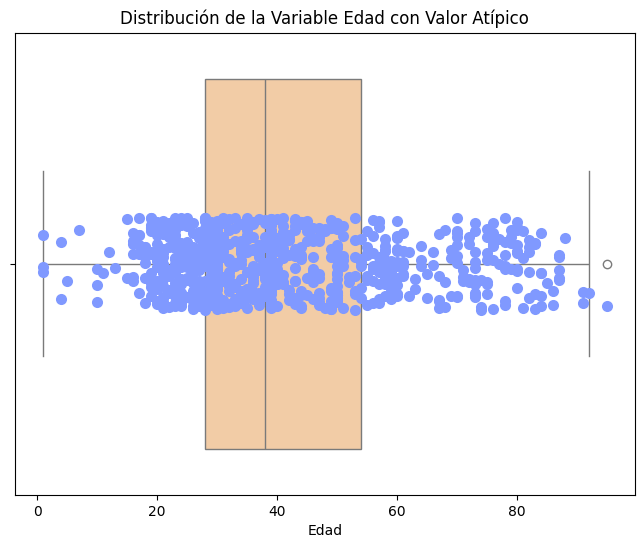

In [180]:
# Establecer la paleta de colores
light_orange = (1.0, 0.8, 0.6)  # Valores RGB para un color naranja apagado y pastel
light_blue = (0.5, 0.6, 1.0)  # Valores RGB para un color celeste pastel

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_homicidios['Edad'], color=light_orange)
sns.stripplot(x=df_homicidios['Edad'], color=light_blue, marker='o', size=8)
plt.xlabel('Edad')
plt.title('Distribución de la Variable Edad con Valor Atípico')
plt.show()


La variable "Edad" tiene una distribución simétrica con una mediana de 38 años, encontrándose la mayoría de las edades entre 28 y 54 años.
Existe un valor atípico de 95 años según el gráfico, que puede NO ser considerado como un outlier, porque tranquilamente podría ser un pasajero en un vehículo accidentado, y la edad es alcanzable por el ser humano.

<br>
<br>

Gráfico de barras con el recuento de víctimas por año

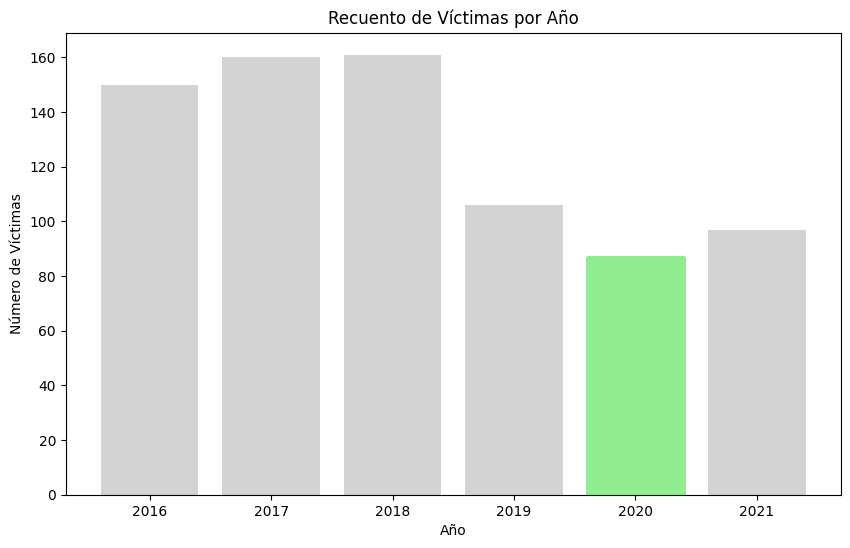

In [181]:
# Crear una nueva columna con el recuento de víctimas por año
df_homicidios['Recuento de Víctimas'] = df_homicidios.groupby('Año')['Nro Víctimas'].transform('count')

# Obtener el año con el menor recuento de víctimas
año_menor_recuento = df_homicidios[df_homicidios['Recuento de Víctimas'] == df_homicidios['Recuento de Víctimas'].min()]['Año'].values[0]

# Crear el gráfico de barras con el recuento de víctimas por año
plt.figure(figsize=(10, 6))
bars = plt.bar(df_homicidios['Año'], df_homicidios['Recuento de Víctimas'], color='lightgrey')

# Resaltar en color el año con el menor recuento de víctimas
for bar in bars:
    if bar.get_height() == df_homicidios['Recuento de Víctimas'].min():
        bar.set_color('lightgreen')

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Número de Víctimas')
plt.title('Recuento de Víctimas por Año')

# Mostrar el gráfico
plt.show()

Se logra ver con claridad que en el año 2020 es el año con menor cantidad de víctimas, dado que el 2020 fue el año en el que argentina transitó el confinamiento por la pandemia mundial covid durante casi 10 meses. Por lo que nos resulta lógico que sea el menor año con víctimas, aunque incluso deberíamos esperar una diferencia mayor respecto de los otros años, considerando la duración del confinamiento

<br>
<br>

Gráfico de barras con el recuento de víctimas por comuna

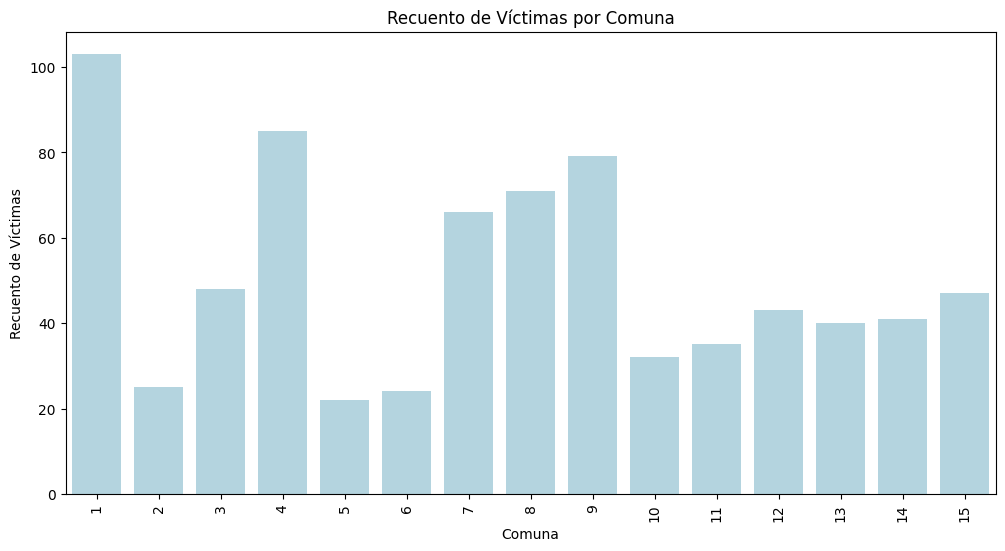

In [182]:
# Crear el gráfico de barras con el recuento de víctimas por comuna
plt.figure(figsize=(12, 6))
sns.countplot(data=df_homicidios, x='Comuna', color='lightblue')

# Personalizar el gráfico
plt.xlabel('Comuna')
plt.ylabel('Recuento de Víctimas')
plt.title('Recuento de Víctimas por Comuna')

# Rotar las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()

<br>
<br>

Gráfico de recuento de Víctimas por Año, por Comuna

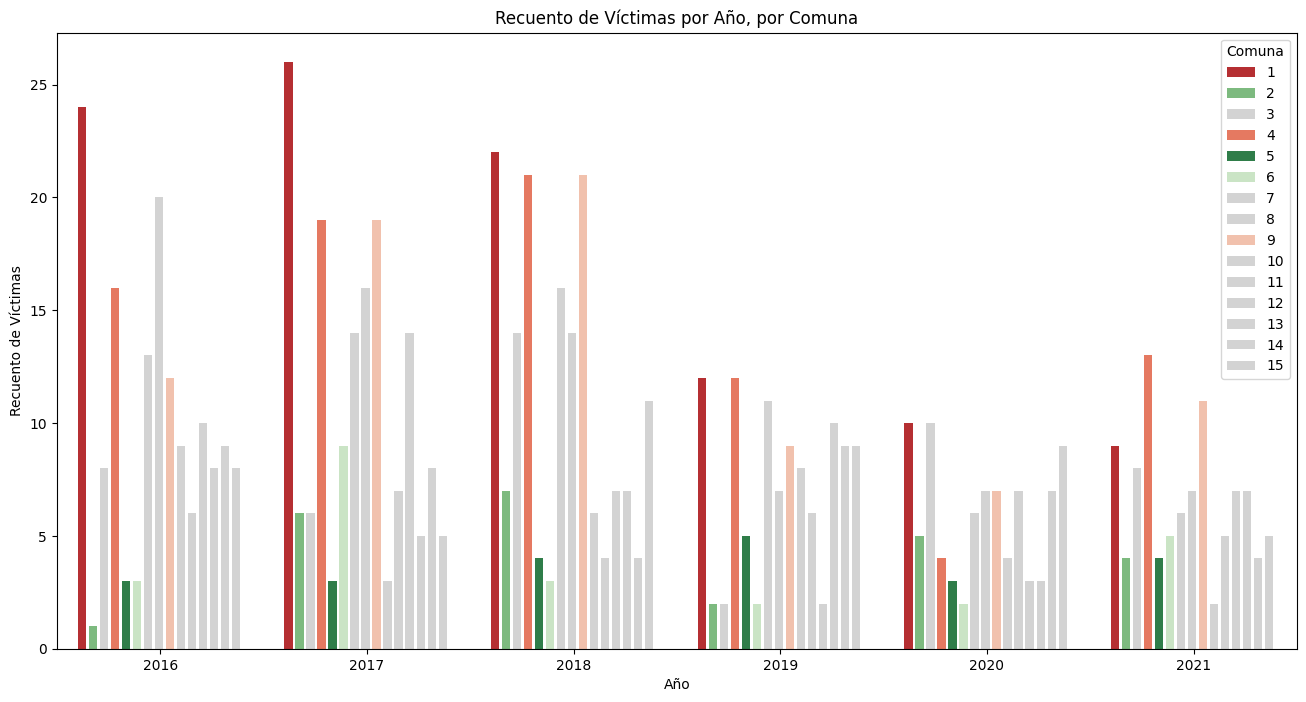

In [191]:
# Calcular las víctimas totales por comuna
df_homicidios['Total Víctimas'] = df_homicidios.groupby('Comuna')['Nro Víctimas'].transform('sum')

# Identificar las comunas con mayor y menor cantidad de víctimas totales
comunas_con_mas_victimas = df_homicidios.groupby('Comuna')['Total Víctimas'].sum().nlargest(3)
comunas_con_menos_victimas = df_homicidios.groupby('Comuna')['Total Víctimas'].sum().nsmallest(3)

# Crear una escala de colores para las comunas con más y menos víctimas
colores_mas_victimas = sns.color_palette("Reds_r", 3)  # De más claro a más oscuro
colores_menos_victimas = sns.color_palette("Greens", 3)  # De más oscuro a más claro

# Asignar colores a las comunas
palette_dict = {}
for comuna in df_homicidios['Comuna'].unique():
    if comuna in comunas_con_mas_victimas.index:
        # Asignar el color según el orden de las víctimas
        idx = comunas_con_mas_victimas.index.get_loc(comuna)
        palette_dict[comuna] = colores_mas_victimas[idx]
    elif comuna in comunas_con_menos_victimas.index:
        # Asignar el color según el orden inverso de las víctimas
        idx = comunas_con_menos_victimas.index.get_loc(comuna)
        palette_dict[comuna] = colores_menos_victimas[::-1][idx]
    else:
        palette_dict[comuna] = 'lightgrey'

# Crear el gráfico
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=df_homicidios, x='Año', hue='Comuna', palette=palette_dict)

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Recuento de Víctimas')
plt.title('Recuento de Víctimas por Año, por Comuna')

# Ajustar el ancho de las columnas
for patch in ax.patches:
    patch.set_width(0.04)

# Mostrar el gráfico
plt.show()


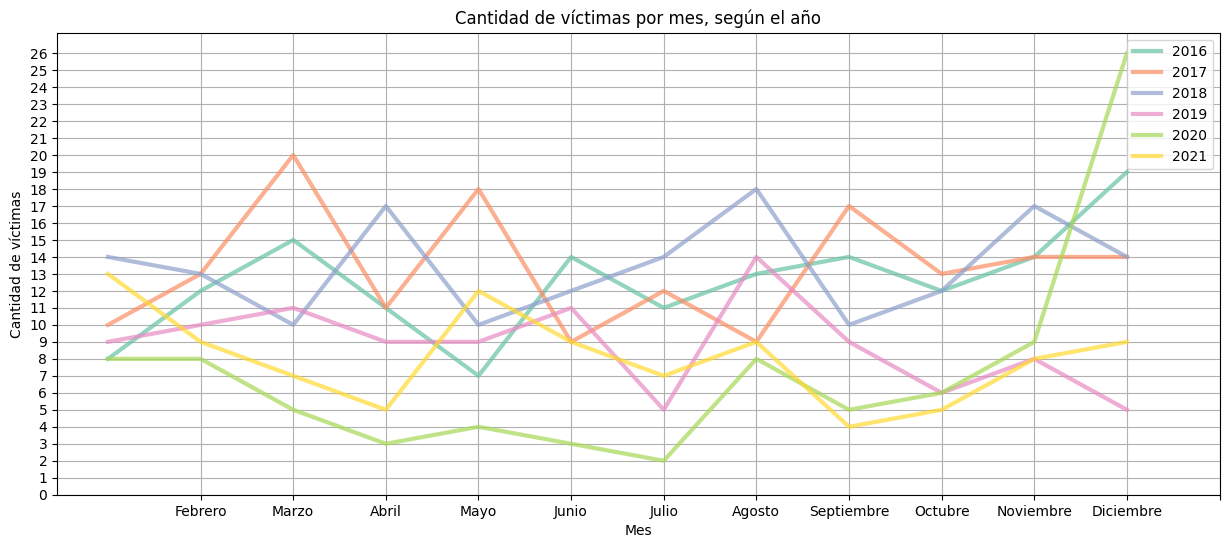

In [184]:
# Definir el orden de los meses
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Contar la cantidad de filas por año y mes
counts = df_homicidios.groupby(['Año', 'Mes']).size().unstack(fill_value=0)

# Reordenar los meses
counts = counts[orden_meses]

# Crear el gráfico de líneas con un grosor uniforme y paleta de colores modificada
plt.figure(figsize=(15, 6))
for year in counts.index:
    plt.plot(counts.columns, counts.loc[year], label=str(year), linewidth=3, alpha=0.7)  # Grosor uniforme y transparencia
sns.set_palette("Set2")  # Cambiar la paleta de colores
plt.xlabel('Mes')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas por mes, según el año')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.yticks(range(0, max(counts.values.max(), 1) + 1))  # Set y-ticks as integers
plt.show()

<br>
<br>

#### Se carga el dataset limpio

In [185]:
df_homicidios.to_csv(r"C:\Users\Cebol\OneDrive\Escritorio\PI_02_siniestros\Datasets\homicidios_limpio.csv", index=False, encoding='utf-8')